In [1]:
import random
import matplotlib.pyplot as plt
import Prettyplots as pp
import numpy as np
from functools import reduce
from sklearn.cluster import KMeans
from scipy.signal import lfilter, gaussian, convolve

In [2]:
def np_step(x, a):
    boolean_arr = np.zeros_like(x).astype(np.int32)
    for col, predicate in enumerate(a):
        boolean_arr[x[:, col] >= predicate, col] = 1
        
    return boolean_arr

def sigmoid(x):
    return 1. / (1. + np.exp(-x))

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

def length(vector, axis=1):
    return np.linalg.norm(vector, ord=None, axis=axis)

def angle_btw(v1, v2):
    return np.array([ np.arccos(np.dot(v1[r], v2[r]) / (length(v1[r], 0)*length(v2[r], 0))) \
              for r in range(0, v1.shape[0]) ])

def lincomb(v_array, weights):
    wsum = np.zeros((v_array.shape[0], ))
    for col in range(0, v_array.shape[1]):
        wsum += weights[col]*v_array[:, col]
        
    return wsum

def curve_salience(curve, wlen=5, sig=1):
    kern_lo = gaussian(wlen, std=sig)
    kern_hi = gaussian(wlen, std=2.0*sig)
    y_lo = convolve(curve, kern_lo, mode='same')
    y_hi = convolve(curve, kern_hi, mode='same')
    return np.abs(y_hi - y_lo)

def candidate_keyframes(salience_curve):
    return np.argwhere(salience_curve > np.mean(salience_curve))

def cluster_keyframes_simple(keyframes, thresh=3):
    itr = 0
    cls = []
    end = len(keyframes)
    for i in range(0, end - 1):
        d = keyframes[i + 1] - keyframes[i]
        if d > thresh:
            cls.append(keyframes[itr:i+1])
            itr = i+1
        
    cls.append(keyframes[itr:end])
    return cls

def cluster_keyframes_kmeans(keyframes, n_clusters):
    to_cluster = keyframes
    dummy_axis = np.arange(len(keyframes))
    X = np.vstack((to_cluster, dummy_axis)).T
    
    kmeans = KMeans(n_clusters=n_clusters, init='random')
    kmeans.fit(X)
    
    cls = [[] for _ in range(n_clusters)]
    for k, l in zip(keyframes, kmeans.labels_):
        cls[l].append(k)
    
    return X, kmeans.labels_, kmeans.cluster_centers_, cls

def nearest_center_kmeans(samples, labels, centers):
    
    nearest = np.zeros_like(centers)
    for idx, cen in enumerate(centers):
        _slice = np.argwhere(labels == idx).flatten()
        _samples = samples[_slice]
        _dists = length(_samples - cen)
        nearest[idx] = _samples[np.argmin(_dists)]
    
    return np.sort(nearest[:, 0])
        
def decimate_keyframes(kfcls, orig_curve):
    kf = []
    curve = orig_curve - np.mean(orig_curve)
    for c in kfcls:
        lmin = np.abs(np.min(curve[c]))
        lmax = np.abs(np.max(curve[c]))

        idx = 0
        if lmin > lmax:
            idx = np.argmin(curve[c])
        else:
            idx = np.argmax(curve[c])

        kf.append(c[idx])
    
    kf.sort()
    return kf

def lpf_motion():
    b = np.array([0.1526249789, 0.0333481282, 0.0777551903, 0.0667145281, 0.0138945068])
    a = np.array([1, -1.7462227354, 1.7354077932, -0.8232679111, 0.1793463694])
    return (b, a)

def lpf_motion_d1():
    b = np.array([0.1973679432, -0.0056567353, -0.0321850947, -0.1099445540, -0.0495815592])
    a = np.array([1, -0.9870779094, 0.7774863652, -0.2206843188, 0.02813441289])
    return (b, a)
    
def lpf_motion_d2():
    b = np.array([-0.0795571277, 0.1390709784, -0.0479192600, -0.0031459045, -0.0084486862])
    a = np.array([1, -1.571029458, 1.459212744, -0.7173743414, 0.1488005975])
    return (b, a)

def filter_motion(b, a, signal, dims):
    out_signals = []
    for dim in range(0, dims):
        x = signal[:, dim]
        y = lfilter(b, a, x)
        out_signals.append(y)
        
    return np.vstack((tuple(out_signals))).T

def lfderivator(coefs, filter_func, data_dict, dims=2):
    return {
        k:filter_func(coefs[0], coefs[1], p, dims) \
            for k, p in data_dict.items()
    }

def dict_operator(op_func=lambda x: x, in_dict={}):
    return {k:op_func(p) for k, p in in_dict.items()}

def dict2mat(in_dict, for_keys=None, transpose=True):
    out_mat = None
    if not for_keys:
        out_mat = np.asarray(list(in_dict.values()))
    else:
        out_mat = np.array([in_dict[k] for k in for_keys])
    
    return out_mat.T if transpose else out_mat


In [3]:
class Gesture(object):
    
    def __init__(self, laban_obj):
        self.__keyframes = laban_obj._LabanApproximator__keyframes
        
        self.nframes = laban_obj.nframes
        self.__weightefforts = np.zeros((self.nframes, ))
        self.__timeefforts   = np.zeros((self.nframes, ))
        self.__spaceefforts  = np.zeros((self.nframes, ))
        
        self.weight_weights = np.array([
            0.1, 0.3, 0.3, 0.15, 0.15
        ])
        self.weight_effectors = [
            'head', 'leftWrist', 'rightWrist', 'leftAnkle', 'rightAnkle'
        ]
        
        self.time_weights = np.array([
            0.3, 0.25, 0.25, 0.1, 0.1
        ]) 
        self.time_effectors = [
            'head', 'leftWrist', 'rightWrist', 'leftAnkle', 'rightAnkle'
        ]
        
        self.space_weights = np.array([
            0.1, 0.225, 0.225, 0.225, 0.225
        ]) 
        self.space_effectors = [
            'head', 'leftWrist', 'rightWrist', 'leftAnkle', 'rightAnkle'
        ]
                
        motion_features = [
            laban_obj.joint_speed,
            laban_obj.joint_mgacc,
            laban_obj.joint_pos
        ]
        
        effectors = [
            self.weight_effectors,
            self.time_effectors,
            self.space_effectors
        ]
        
        effort_funcs = [
            self.weight_effort,
            self.time_effort,
            self.space_effort
        ]
        
        efforts = [
            self.__weightefforts,
            self.__timeefforts,
            self.__spaceefforts
        ]
        
        package = zip(motion_features, effectors, effort_funcs, efforts)
        for x, y, z, w in package:
            self.__push_effort(x, y, z, w)

    def get_motion_features(self):
        return np.vstack((
            self.__weightefforts,
            self.__timeefforts,
            self.__spaceefforts
        )).T
    
    def weight_effort(self, segment_matrix):
        mat_sqr = np.power(segment_matrix, 2.)
        mat_w = np.dot(mat_sqr, self.weight_weights)
        return np.amax(mat_w)
        
    def time_effort(self, segment_matrix):
        T = segment_matrix.shape[0]
        mat_sum = np.sum(segment_matrix, axis=0) / T
        return np.dot(mat_sum, self.time_weights)
    
    def space_effort(self, segment_matrix):
        tot_displacement2d = segment_matrix[:, 1:] - segment_matrix[:, 0:-1]
        tot_displacement1d = length(tot_displacement2d, axis=2)
        tot_disp_sum = np.sum(tot_displacement1d, axis=1)
        displacement2d = segment_matrix[:, -1] - segment_matrix[:, 0]
        displacement1d = length(displacement2d)
        disp_ratio = np.divide(displacement1d, tot_disp_sum + 0.001)
        return np.dot(disp_ratio, self.space_weights)
        
    def __push_effort(self, mfeature, jointseg, effort_func, out_arr):
        for idx, segment in enumerate(self.__iseg(mfeature, jointseg)):
            out_arr[idx] = effort_func(segment)
        
    def __iseg(self, mfeature, jointseg):
        isnd = len(mfeature['head'].shape) > 1
        fmat = dict2mat(mfeature, jointseg, not isnd)
        for i in range(0, len(self.__keyframes) - 1):
            lo = self.__keyframes[i]
            hi = self.__keyframes[i + 1]
            yield fmat[:, lo:hi] if isnd else fmat[lo:hi, :]
     
    
class LabanApproximator(object):
    
    h_pairs = [
        ('rightShoulder', 'rightElbow'), ('rightElbow', 'rightWrist'),
        ('leftShoulder', 'leftElbow'), ('leftElbow', 'leftWrist'),
        ('rightHip', 'rightKnee'), ('rightKnee', 'rightAnkle'),
        ('leftHip', 'leftKnee'), ('leftKnee', 'leftAnkle')
    ]
    
    def __init__(self, lma_segment):
        self.scaling = 100.
        
        self.frameRate = lma_segment.meta_data['frameRate']
        self.joint_keys = lma_segment.joint_keys
        
        f = filter_motion
        data = dict_operator(self.world_scale, lma_segment.joint_data)
        self.joint_pos = lfderivator(lpf_motion(),    f, data)
        self.joint_vel = lfderivator(lpf_motion_d1(), f, data)
        self.joint_acc = lfderivator(lpf_motion_d2(), f, data)
        self.joint_speed = dict_operator(length, self.joint_vel)
        self.joint_mgacc = dict_operator(length, self.joint_acc)
        self.bone_angles = self.bone_angle_array() 
        
        self.wlen = 3
        self.sig  = 1.25
        self.cluster_dist1 = self.wlen
        self.n_clusters = 7
        self.n_itr = 30
        self.lin_weights = np.ones((self.bone_angles.shape[1], )) / self.bone_angles.shape[1]
        
        self.__keyframes, self.__rcurve = self.keyframes()
        self.nframes = len(self.__keyframes) - 1
        self.__gesture = Gesture(self)
        

    def get_motion_features(self):
        return self.__gesture.get_motion_features()
    
    def world_scale(self, array):
        return np.multiply(array, self.scaling)
    
    def bone_angle_array(self):
        p = self.joint_pos
        root = np.array([0, 0])
        clav = (p['leftHip'] + p['rightHip']) / 2.
        center_bone = clav - root
                
        return np.asarray([
            angle_btw(v, center_bone) for v in [
                p[bp[1]] - p[bp[0]] for bp in LabanApproximator.h_pairs
            ]
        ]).T
        
    def keyframes(self):
        keyframes = []
        a = self.bone_angles
        for col in range(0, a.shape[1]):
            curve = a[:, col]
            salience = curve_salience(curve, self.wlen, self.sig)
            candidkf = candidate_keyframes(salience)
            kcluster = cluster_keyframes_simple(candidkf, self.cluster_dist1)
            keyframes.append(decimate_keyframes(kcluster, curve))

        k = reduce(np.union1d, tuple(keyframes))
        _, _, _, cls = cluster_keyframes_kmeans(k, n_clusters=self.n_clusters)
        ref_curve = lincomb(a, self.lin_weights)
        out_keyframes = decimate_keyframes(cls, ref_curve)
        #nearest_center_kmeans(X, lab, cen).astype(np.int32)
        return (out_keyframes, ref_curve)
    
    def plt_keyframes(self, fignum=0, figsize=(10, 8)):
        fig, axs = plt.subplots(2, 1, num=fignum, figsize=figsize)
        pp.plt_keyframe_curve(axs[0], self.__keyframes, self.__rcurve)
        pp.plt_keyframe_skeleton(axs[1], self.__keyframes, self.joint_pos, 200./self.scaling)
        axs[1].set_ylim(self.scaling / 2., -self.scaling / 2.)
        plt.show()
        

In [4]:
class LMARunner(object):
    
    action_efforts = np.array([
        [[0, 1], [2, 3]], [[4, 5], [6, 7]]
    ])
    
    def __init__(self, video_segments):
        self.lma_list = []
        feature_list = []
        for seg in video_segments:
            lma = LabanApproximator(seg)
            self.lma_list.append(lma)
            
            feature = lma.get_motion_features()
            feature_list.append(feature)
        
        self.nframes = len(self.lma_list)
        self.ngestures = self.lma_list[0].nframes 
        self.motion_features_raw = np.vstack(tuple(feature_list))
        self.motion_features_log = self.motion_features_raw.copy()
        self.motion_features_log[:, 0:2] = np.log10(self.motion_features_raw.copy()[:, 0:2])
        
        self.weight_thresh = np.mean(self.motion_features_log[:, 0])# +\
        #    np.std(self.motion_features_log[:, 0])
        
        self.time_thresh = np.mean(self.motion_features_log[:, 1])# +\
        #    np.std(self.motion_features_log[:, 1])
        
        self.space_thresh = 0.55
        
        self.action_effort_encoded = self.__action_effort(self.motion_features_log)
        self.action_effort_encoded_ = self.action_effort_encoded.reshape((
            self.nframes, 
            self.ngestures
        ))
        
    def __basic_effort(self, effort_features):
        predicates = zip([self.weight_thresh, self.time_thresh, self.space_thresh])
        return np_step(effort_features, predicates)
    
    def __action_effort(self, effort_features):
        p = self.__basic_effort(effort_features)
        return LMARunner.action_efforts[p[:, 0], p[:, 1], p[:, 2]]
    
    def dataframe(self):
        '''
            TODO:
        '''
        pass
    
    def plot_keyframes_for(self, frame_num, fignum=0):
        self.lma_list[frame_num].plt_keyframes(fignum=fignum)
        

In [5]:
from LMAJSONUtil import LMAJSONUtil
from LMAJSONUtil import joint_keys, joint_indeces, meta_keys
util = LMAJSONUtil(joint_keys, joint_indeces, meta_keys)
v = util.get_video_segments('./json/partial/', None)

[*]  Processing files...
[*]  Processed 191 files


In [6]:
runner = LMARunner(v)

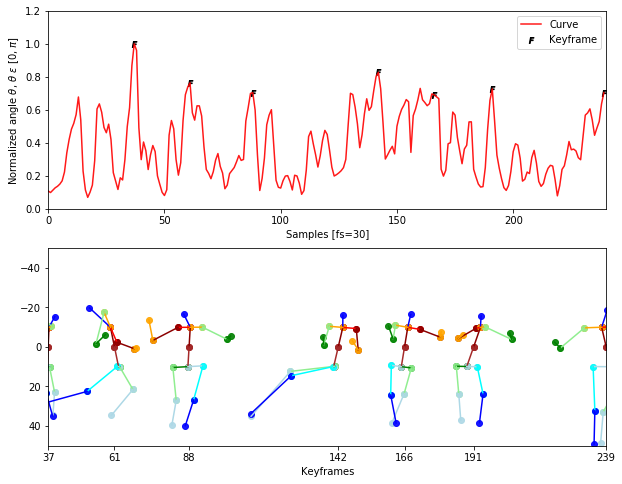

In [7]:
runner.plot_keyframes_for(frame_num=40)

In [8]:
mf = runner.motion_features_raw.copy()

mf_log = mf.copy()
mf_log[:, 0:2] = np.log10(mf_log[:, 0:2])

mf_tanh = np.tanh(mf.copy())

mf_log_tanh = mf_log.copy()
mf_log_tanh[:, 0:2] = np.tanh(mf_log_tanh[:, 0:2])

1.5941164637865932
0.5320383910331947
-0.2169814703214328
0.2570103902580592
0.20788708360630492
0.1430846581995935


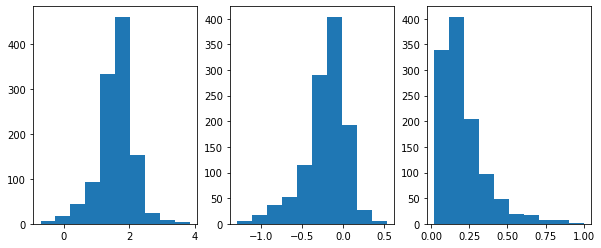

In [9]:
fig = plt.figure(0, figsize=(10, 4))
ax0 = fig.add_subplot(131)
ax1 = fig.add_subplot(132)
ax2 = fig.add_subplot(133)

ax0.hist(mf_log[:, 0])
print(np.mean(mf_log[:, 0]))
print(np.std(mf_log[:, 0]))

ax1.hist(mf_log[:, 1])
print(np.mean(mf_log[:, 1]))
print(np.std(mf_log[:, 1]))

ax2.hist(mf_log[:, 2])
print(np.mean(mf_log[:, 2]))
print(np.std(mf_log[:, 2]))


plt.show()



In [10]:
print(runner.action_effort_encoded_[0:100])

[[0 4 0 0 1 0]
 [0 0 0 0 0 0]
 [4 0 0 0 1 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [1 0 0 0 0 0]
 [4 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [2 4 6 0 6 4]
 [6 4 6 4 6 2]
 [0 0 2 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [4 6 6 4 0 0]
 [6 6 6 6 6 2]
 [6 6 6 6 1 6]
 [6 2 0 0 6 6]
 [6 6 6 0 6 6]
 [6 6 6 6 4 5]
 [6 6 6 6 4 6]
 [6 4 2 6 6 6]
 [0 0 0 0 0 0]
 [4 6 6 6 3 6]
 [0 6 6 6 4 6]
 [6 6 2 6 6 0]
 [6 6 4 6 6 6]
 [6 6 6 6 0 0]
 [4 6 0 0 6 0]
 [6 6 6 6 0 0]
 [0 0 6 6 6 6]
 [6 6 7 6 0 6]
 [6 6 6 6 4 6]
 [6 6 6 6 6 4]
 [1 0 0 0 4 6]
 [6 6 6 6 6 6]
 [6 0 0 2 6 6]
 [6 0 2 6 0 2]
 [6 6 0 6 2 6]
 [6 6 6 7 6 0]
 [6 6 0 0 6 6]
 [6 6 6 2 6 6]
 [6 6 6 6 6 6]
 [6 6 6 3 6 6]
 [6 0 0 6 6 6]
 [4 6 6 6 6 4]
 [6 6 6 6 6 6]
 [6 1 6 6 6 6]
 [6 6 6 6 6 6]
 [6 6 6 6 6 6]
 [6 6 6 6 6 6]
 [6 6 7 6 6 6]
 [2 2 0 0 6 2]
 [2 6 4 6 2 6]
 [6 2 2 0 2 6]
 [4 6 6 0 0 2]
 [0 0 0 0 6 4]
 [0 0 0 0 0 6]
 [4 6 6 6 6 6]
 [0 0 6 2 0 3]
 [2 2 0 2 2 6]
 [2 6 6 0 4 6]
 [6 0 6 6 6 6]
 [6 6 6 6 6 6]
 [6 6 6 6 